# GW Legacy Object and Target Identification

Using the DR8 Legacy Survey, identify all objects within the 90% credible interval of a GW alert angular reconstruction.

Then compare the selected objects against the bright targets selected from DR8.

In [1]:
import os
import numpy as np
from astropy.io import fits
from astropy.table import Table, Column, join, hstack, vstack
try:
    from astropy.cosmology import Planck18_arXiv_v2
    cosmo = Planck18_arXiv_v2
except ImportError as e:
    from astropy.cosmology import Planck15
    cosmo = Planck15

import logging
import numpy as np
import healpy as hp
import matplotlib as mpl
import matplotlib.pyplot as plt

from gw_skymap import compute_quantiles, compute_contours, plot_gwmap

from desitarget import io, cuts
from desitarget.targetmask import desi_mask, bgs_mask

## DR8 Access Functions

Use the `desitarget.io` interface to access the DR8 sweep files and the corresponding photo-z catalogs. For more information see the [Legacy Survey DR8 File Directory](http://legacysurvey.org/dr8/files/) and the [photo-z catalog](https://arxiv.org/abs/2001.06018) developed for DR8 by Rongpu Zhou et al.

In [2]:
def get_sweepfiles(sweepfolders=['/global/project/projectdirs/cosmo/data/legacysurvey/dr8/north/sweep/8.0', '/global/project/projectdirs/cosmo/data/legacysurvey/dr8/south/sweep/8.0']):
    """Given a search folder or folders, return a list of sweep files.
    
    For details on file locations see For details see http://legacysurvey.org/dr8/files/.
    
    Parameters
    ----------
    sweepfolders : str or list
        A folder or list of folders to search for sweep files.
    
    Returns
    -------
    sweeplist : list
        List of sweep files.
    """
    sweeplist = None
    
    if np.isscalar(sweepfolders):
        sweeplist = io.list_sweepfiles(sweepfolders)
    else:
        for fldr in sweepfolders:
            if sweeplist is None:
                sweeplist = io.list_sweepfiles(fldr)
            else:
                sweeplist += io.list_sweepfiles(fldr)
                
    return sweeplist

def get_objects_in_gw_contour(sweepfolders, lvc_hp_file, level=0.9):
    # Get luminosity distance to GW.
    # Read metadata.
    hdus = fits.open(lvc_hp_file)
    header = hdus[1].header
    distmean = header['DISTMEAN']
    diststd = header['DISTSTD']
    
    # Get contours for the GW skymap.
    gwmap = hp.read_map(lvc_hp_file)
    gw_maxprob = np.max(gwmap)
    npix = len(gwmap)
    nside = hp.npix2nside(npix)
    thresh = compute_quantiles([level], gwmap)[0]
    logging.info('{:g}% confidence level of GW map {:s} = {:g}'.format(100*level, lvc_hp_file, thresh))
    
    # Get list of pixels above threshold defined by level.
    pixels = hp.ring2nest(nside, np.arange(npix))
    pixids = pixels[gwmap > thresh]
    
    # Loop through all sweeps, see if pixel indices match with any bricks.
    sweepfiles = get_sweepfiles(sweepfolders)
    gwsweeps = []
    for sf in sweepfiles:
        ramin, ramax, decmin, decmax = io.decode_sweep_name(sf)
        ra = [ramin, ramax, ramax, ramin]
        dec = [decmin, decmin, decmax, decmax]
        box = hp.ang2vec(ra, dec, lonlat=True)
        boxpix = hp.query_polygon(nside, box, nest=True)
        
        if not set(boxpix).isdisjoint(pixids):
            gwsweeps.append(sf)

    # Grab photo-z data and read everything into a table.
    gwspeeps, photozs = get_sweep_photo_z(gwsweeps)
    
    objtab = None
    for sf, pz in zip(gwsweeps, photozs):
        print(sf)
        data = Table(io.read_tractor(sf, columns=['BRICKID', 'BRICKNAME', 'OBJID', 'RA', 'DEC']))
        data_pz = Table.read(pz)
        
        # Cut pixels not in 
        brickpix = hp.ang2pix(nside, data['RA'], data['DEC'], lonlat=True, nest=True)
        gw_prob = gwmap[hp.nest2ring(nside, brickpix)] / gw_maxprob
        data.add_column(Column(name='Pr_radec', data=gw_prob))
        
        in_gw = np.isin(brickpix, pixids)
        valid_z = data_pz['z_phot_mean'] >= 0
        select = np.logical_and(in_gw, valid_z)
        
        if objtab is None:
            objtab = hstack([data[select], data_pz[select]])
        else:
            objtab = vstack([objtab, hstack([data[select], data_pz[select]])])
            
    # Compute luminosity distance given mean photo-z.
    nonzero_prob = objtab['Pr_radec'] > 0
    logging.info('Computing luminosity distances for {:d} objects.'.format(np.sum(nonzero_prob)))
    
    d_L = np.zeros(len(objtab))
    d_L[nonzero_prob] = cosmo.luminosity_distance(objtab[nonzero_prob]['z_phot_mean']).to('Mpc').value
    objtab.add_column(Column(name='D_L', data=d_L))
    
    # Compute distance probability relative to max.
    d_L_res = np.zeros(len(objtab))
    d_L_res[nonzero_prob] = (d_L[nonzero_prob] - distmean)/diststd
    objtab.add_column(Column(name='D_L_residual', data=d_L_res))
    
    pr_d_L = np.zeros(len(objtab))
    pr_d_L[nonzero_prob] = np.exp(-0.5*((d_L[nonzero_prob] - distmean)/diststd)**2)
    objtab.add_column(Column(name='Pr_D_L', data=pr_d_L))

    return objtab
    
def get_sweep_photo_z(sweepfiles):
    # Search for matching photo-z files.
    sweeplist = sweepfiles
    photozlist = None
    logging.warning('Photo-z search hardcoded for DR8 v8.0.')

    for sweep in sweeplist:
        sweep_pz = sweep.replace('8.0', '8.0-photo-z').replace('.fits', '-pz.fits')

        # If photo-z file not found, remove corresponding sweep file from list.
        if os.path.exists(sweep_pz):
            if photozlist is None:
                photozlist = [sweep_pz]
            else:
                photozlist.append(sweep_pz)
        else:
            sweeplist.remove(sweep)
            
    return sweeplist, photozlist

### Access DR8 Catalog Data

Grab DR8 objects inside the 90% contour of a GW alert.

In [3]:
logging.basicConfig(level=logging.INFO)

sweepfolders=['/global/project/projectdirs/cosmo/data/legacysurvey/dr8/north/sweep/8.0',
              '/global/project/projectdirs/cosmo/data/legacysurvey/dr8/south/sweep/8.0']

gwfile = 'S200224ca_LALInference.fits.gz'

objcat = get_objects_in_gw_contour(sweepfolders, gwfile)

NSIDE = 1024
ORDERING = NESTED in fits file
INDXSCHM = IMPLICIT
Ordering converted to RING


INFO:root:90% confidence level of GW map S200224ca_LALInference.fits.gz = 5.23602e-06


/global/project/projectdirs/cosmo/data/legacysurvey/dr8/south/sweep/8.0/sweep-160p010-170p015.fits
/global/project/projectdirs/cosmo/data/legacysurvey/dr8/south/sweep/8.0/sweep-160p015-170p020.fits
/global/project/projectdirs/cosmo/data/legacysurvey/dr8/south/sweep/8.0/sweep-160m005-170p000.fits
/global/project/projectdirs/cosmo/data/legacysurvey/dr8/south/sweep/8.0/sweep-170m010-180m005.fits
/global/project/projectdirs/cosmo/data/legacysurvey/dr8/south/sweep/8.0/sweep-160p000-170p005.fits
/global/project/projectdirs/cosmo/data/legacysurvey/dr8/south/sweep/8.0/sweep-170m005-180p000.fits
/global/project/projectdirs/cosmo/data/legacysurvey/dr8/south/sweep/8.0/sweep-160p005-170p010.fits
/global/project/projectdirs/cosmo/data/legacysurvey/dr8/south/sweep/8.0/sweep-170p000-180p005.fits


INFO:root:Computing luminosity distances for 5400508 objects.


In [4]:
objcat

BRICKID,BRICKNAME,OBJID,RA,DEC,Pr_radec,z_phot_mean,z_phot_median,z_phot_std,z_phot_l68,z_phot_u68,z_phot_l95,z_phot_u95,z_spec,survey,training,D_L,D_L_residual,Pr_D_L
int32,bytes8,int32,float64,float64,float64,float32,float32,float32,float32,float32,float32,float32,float32,str10,bool,float64,float64,float64
391213,1638p105,13,163.91044829909848,10.375358494095341,0.027714476866631654,0.5342261,0.5426291,0.08195053,0.470757,0.59792954,0.32785872,0.6688287,-99.0,,False,3159.605965711192,4.853169421941666,7.682030029040935e-06
391213,1638p105,15,163.91079213423245,10.376251016827908,0.027714476866631654,1.1720649,1.150069,0.16198546,1.0282513,1.3064152,0.95441574,1.5760465,-99.0,,False,8261.149345679836,20.02467433716319,8.446034394236358e-88
391213,1638p105,18,163.824445479138,10.379335311153516,0.027714476866631654,0.7397979,0.73783517,0.06575013,0.6745122,0.79668057,0.64354104,0.8707141,-99.0,,False,4690.056534930087,9.404583886940445,6.225182857580001e-20
391213,1638p105,19,163.8278916127404,10.38003918016361,0.027714476866631654,0.96629965,0.96591806,0.11836857,0.8515245,1.0735929,0.7441341,1.211403,-99.0,,False,6510.843596431635,14.819431472400412,2.046866078278346e-48
391213,1638p105,20,163.8271506358486,10.378847153776396,0.027714476866631654,0.53313255,0.5362221,0.17684649,0.3468765,0.6823131,0.21882549,0.9465533,-99.0,,False,3151.8321864806658,4.830050941705102,8.591853683477629e-06
391213,1638p105,21,163.82355191123185,10.376452451237274,0.027714476866631654,0.8876859,0.8857769,0.118527584,0.7818576,0.9916952,0.66354215,1.1137693,-99.0,,False,5864.999700207231,12.898753137191473,7.43896847705918e-37
391213,1638p105,22,163.82640983831237,10.380654901883746,0.027714476866631654,0.8180383,0.80971324,0.15604389,0.7015501,0.96458286,0.45561847,1.1107563,-99.0,,False,5304.785685534144,11.232729927321019,3.995911821162359e-28
391213,1638p105,24,163.82575419441739,10.376367928987372,0.027714476866631654,1.0080067,0.9968767,0.13941793,0.8890845,1.1234735,0.74404746,1.3003805,-99.0,,False,6858.910883840779,15.854550488047813,2.6085500371537314e-55
391213,1638p105,25,163.82621475839582,10.379526560972241,0.027714476866631654,1.1787049,1.1716869,0.14234334,1.0441034,1.3074011,0.94922066,1.5421838,-99.0,,False,8318.936355504753,20.196527409517163,2.6650253633606806e-89


### Plot Contours and Targets

NSIDE = 1024
ORDERING = NESTED in fits file
INDXSCHM = IMPLICIT
Ordering converted to RING
NSIDE = 1024
ORDERING = NESTED in fits file
INDXSCHM = IMPLICIT
Ordering converted to RING


INFO:root:RA_min=162.3, RA_max=177.8, Dec_min=-14.8, Dec_max=15.9


0.0 180.0 -180.0 180.0
The interval between parallels is 30 deg -0.00'.
The interval between meridians is 45 deg 0.00'.


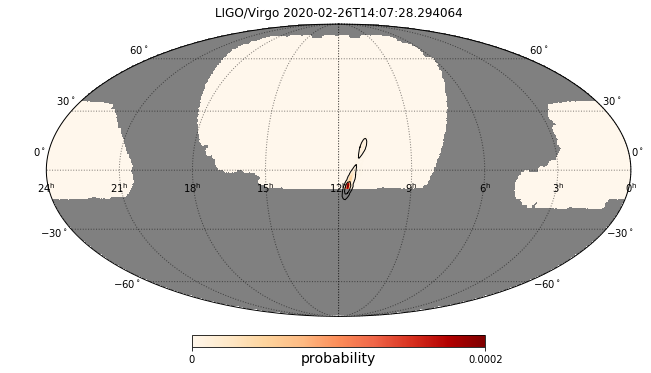

In [5]:
fig = plot_gwmap(gwfile)

NSIDE = 1024
ORDERING = NESTED in fits file
INDXSCHM = IMPLICIT
Ordering converted to RING


/global/common/software/desi/cori/desiconda/20190804-1.3.0-spec/conda/lib/python3.6/site-packages/matplotlib/figure.py:2022: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


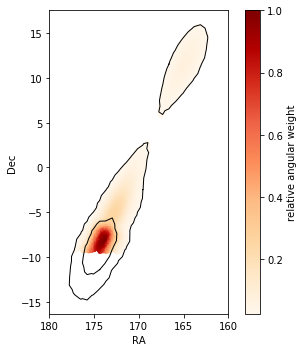

In [6]:
# Plot legacy targets color-coded by relative angular probability from GW event.
fig, ax = plt.subplots(1,1, figsize=(5,5), tight_layout=True)
sc = ax.scatter(objcat['RA'][::100], objcat['DEC'][::100], s=0.1, c=objcat['Pr_radec'][::100], cmap='OrRd')
cb = fig.colorbar(sc, ax=ax)
cb.set_label('relative angular weight')

# Compute GW contours for degraded map.
gwmap = hp.read_map(gwfile)
gwmap64 = hp.pixelfunc.ud_grade(gwmap, 64) #reduce nside to make it faster
gwmap64 = gwmap64/np.sum(gwmap64)
ra_contour, dec_contour = compute_contours([0.5, 0.9], gwmap64)
for i, (rc, dc) in enumerate(zip(ra_contour, dec_contour)):
    ax.plot(rc, dc, linewidth=1, color='k')

ax.set(xlim=(180,160), xlabel='RA', ylabel='Dec', aspect='equal');

292489 / 5400508 = 5.4% in D_L 90% region


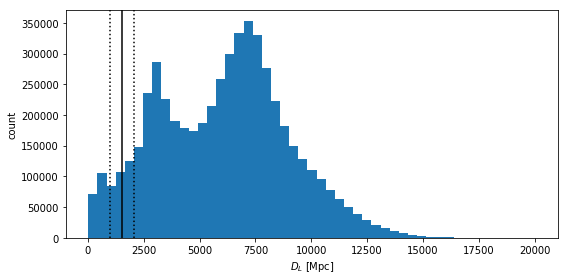

In [7]:
dL_min = np.min(objcat['D_L'])
dL_max = np.max(objcat['D_L'])

hdus = fits.open(gwfile)
header = hdus[1].header
distmean = header['DISTMEAN']
diststd = header['DISTSTD']
dl90_lo = distmean - 1.645*diststd
dl90_hi = distmean + 1.645*diststd

select = np.logical_and(objcat['D_L'] > dl90_lo, objcat['D_L'] < dl90_hi)
print('{:d} / {:d} = {:.1f}% in D_L 90% region'.format(np.sum(select), len(objcat), 1e2*np.sum(select)/len(objcat)))

fig, ax = plt.subplots(1,1, figsize=(8,4), tight_layout=True)
ax.hist(objcat['D_L'], bins=np.linspace(dL_min, dL_max, 50))
ax.axvline(distmean, color='k', ls='-')
ax.axvline(dl90_lo, color='k', ls=':')
ax.axvline(dl90_hi, color='k', ls=':')
ax.set(xlabel='$D_L$ [Mpc]',
       ylabel='count');

## Merge with DR8 Bright Target List

Grab the legacy object catalog and merge it with the bright target list constructed from DR8.

In [8]:
# Load sample of resolved DR8 target catalog using HEALPixels above threshold in the GW map.
npix = len(gwmap)
nside = hp.npix2nside(npix)
lev90 = compute_quantiles([0.9], gwmap)[0]

# Get list of pixels above threshold defined by level.
pixels = hp.ring2nest(nside, np.arange(npix))
pix90 = pixels[gwmap > lev90]

hpdirname = '/global/projecta/projectdirs/desi/target/catalogs/dr8/0.32.0/targets/main/resolve/bright'
targ90 = io.read_targets_in_hp(hpdirname, nside=nside, pixlist=pix90)

INFO:io.py:1828:read_target_files: Read 2490257 targets from targets-dr8-hp-8.fits, extension TARGETS...Took 0.7s


INFO:desiutil.log.dlm58.info:Read 2490257 targets from targets-dr8-hp-8.fits, extension TARGETS...Took 0.7s


INFO:io.py:1828:read_target_files: Read 282863 targets from targets-dr8-hp-24.fits, extension TARGETS...Took 0.1s


INFO:desiutil.log.dlm58.info:Read 282863 targets from targets-dr8-hp-24.fits, extension TARGETS...Took 0.1s


INFO:io.py:1828:read_target_files: Read 1926328 targets from targets-dr8-hp-27.fits, extension TARGETS...Took 0.6s


INFO:desiutil.log.dlm58.info:Read 1926328 targets from targets-dr8-hp-27.fits, extension TARGETS...Took 0.6s


INFO:io.py:1828:read_target_files: Read 1932469 targets from targets-dr8-hp-26.fits, extension TARGETS...Took 0.9s


INFO:desiutil.log.dlm58.info:Read 1932469 targets from targets-dr8-hp-26.fits, extension TARGETS...Took 0.9s


### Select Bright Targets

In [9]:
bgs_bright = (targ90['BGS_TARGET'] & bgs_mask['BGS_BRIGHT']) != 0
print('{:d} / {:d} = {:.1f}% are BGS bright targets'.format(np.sum(bgs_bright), len(targ90), 1e2*np.sum(bgs_bright)/len(targ90)))
btarg90 = targ90[bgs_bright]

60430 / 174885 = 34.6% are BGS bright targets


### Merge Bright Target List and Legacy Object List

In [10]:
bmerg90 = join(btarg90, objcat)
bmerg90

RELEASE,BRICKID,BRICKNAME,BRICK_OBJID,MORPHTYPE,RA,RA_IVAR,DEC,DEC_IVAR,DCHISQ [5],EBV,FLUX_G,FLUX_R,FLUX_Z,FLUX_IVAR_G,FLUX_IVAR_R,FLUX_IVAR_Z,MW_TRANSMISSION_G,MW_TRANSMISSION_R,MW_TRANSMISSION_Z,FRACFLUX_G,FRACFLUX_R,FRACFLUX_Z,FRACMASKED_G,FRACMASKED_R,FRACMASKED_Z,FRACIN_G,FRACIN_R,FRACIN_Z,NOBS_G,NOBS_R,NOBS_Z,PSFDEPTH_G,PSFDEPTH_R,PSFDEPTH_Z,GALDEPTH_G,GALDEPTH_R,GALDEPTH_Z,FLUX_W1,FLUX_W2,FLUX_W3,FLUX_W4,FLUX_IVAR_W1,FLUX_IVAR_W2,FLUX_IVAR_W3,FLUX_IVAR_W4,MW_TRANSMISSION_W1,MW_TRANSMISSION_W2,MW_TRANSMISSION_W3,MW_TRANSMISSION_W4,ALLMASK_G,ALLMASK_R,ALLMASK_Z,FRACDEV,FRACDEV_IVAR,SHAPEDEV_R,SHAPEDEV_E1,SHAPEDEV_E2,SHAPEDEV_R_IVAR,SHAPEDEV_E1_IVAR,SHAPEDEV_E2_IVAR,SHAPEEXP_R,SHAPEEXP_E1,SHAPEEXP_E2,SHAPEEXP_R_IVAR,SHAPEEXP_E1_IVAR,SHAPEEXP_E2_IVAR,FIBERFLUX_G,FIBERFLUX_R,FIBERFLUX_Z,FIBERTOTFLUX_G,FIBERTOTFLUX_R,FIBERTOTFLUX_Z,WISEMASK_W1,WISEMASK_W2,MASKBITS,REF_ID,REF_CAT,GAIA_PHOT_G_MEAN_MAG,GAIA_PHOT_G_MEAN_FLUX_OVER_ERROR,GAIA_PHOT_BP_MEAN_MAG,GAIA_PHOT_BP_MEAN_FLUX_OVER_ERROR,GAIA_PHOT_RP_MEAN_MAG,GAIA_PHOT_RP_MEAN_FLUX_OVER_ERROR,GAIA_PHOT_BP_RP_EXCESS_FACTOR,GAIA_ASTROMETRIC_EXCESS_NOISE,GAIA_DUPLICATED_SOURCE,GAIA_ASTROMETRIC_SIGMA5D_MAX,GAIA_ASTROMETRIC_PARAMS_SOLVED,PARALLAX,PARALLAX_IVAR,PMRA,PMRA_IVAR,PMDEC,PMDEC_IVAR,PHOTSYS,TARGETID,DESI_TARGET,BGS_TARGET,MWS_TARGET,SUBPRIORITY,OBSCONDITIONS,PRIORITY_INIT,NUMOBS_INIT,HPXPIXEL,OBJID,Pr_radec,z_phot_mean,z_phot_median,z_phot_std,z_phot_l68,z_phot_u68,z_phot_l95,z_phot_u95,z_spec,survey,training,D_L,D_L_residual,Pr_D_L
int16,int32,bytes8,int32,bytes4,float64,float32,float64,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,int16,int16,int16,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,int16,int16,int16,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,uint8,uint8,int16,int64,bytes2,float32,float32,float32,float32,float32,float32,float32,float32,bool,float32,int8,float32,float32,float32,float32,float32,float32,bytes1,int64,int64,int64,int64,float64,int64,int64,int64,int64,int32,float64,float32,float32,float32,float32,float32,float32,float32,float32,str10,bool,float64,float64,float64
8000,275126,1725m097,184,DEV,172.397019956299,616003340000.0,-9.625482671555487,842793800000.0,52184.727 .. 60414.64,0.033260237,5.088146,23.231958,50.45125,100.42422,27.973269,16.785515,0.9062346,0.9358293,0.96358216,0.0,0.0,0.0,0.018731784,0.01807647,0.021485059,0.98545164,0.9849796,0.98210424,1,1,1,527.53754,168.4194,64.93422,291.96332,97.50504,40.738358,74.96227,47.10866,-65.4063,542.51215,1.96097,0.37749872,0.0006767763,9.162152e-06,0.9943792,0.99654436,0.999262,0.9997213,0,0,0,1.0,1.0,1.0653543,-0.22066396,-0.13420337,11931.542,15991.07,11962.243,0.0,0.0,0.0,0.0,0.0,0.0,1.8474888,8.435447,18.318678,1.8474888,8.435447,18.318678,0,0,0,0,,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,False,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,S,35185526050914488,1152921504606846976,131074,0,0.15774548854096537,4,2100,1,25510,184,0.05896313262900739,0.33340856,0.3332893,0.018182486,0.31957218,0.3482954,0.30048284,0.36713898,-99.0,,False,1809.365591051895,0.837682939692056,0.7040848857625639
8000,275126,1725m097,94,REX,172.40801230583185,156102740000.0,-9.631184807287655,151310470000.0,15653.725 .. 0.0,0.03313878,8.937437,17.706902,27.16732,72.77535,26.69763,15.151477,0.9065605,0.93605596,0.9637127,0.014215706,0.011350997,0.011362921,0.0023840985,0.0021772694,0.005493931,0.9996052,0.99996865,0.99924326,1,1,1,527.53754,168.4194,64.93422,291.96332,97.50504,40.738358,25.505836,19.958296,85.839455,-1688.9495,2.1406276,0.4048654,0.0007074306,9.7326665e-06,0.9943997,0.99655694,0.9992647,0.9997223,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.1174004,0.0,0.0,14685.068,0.0,0.0,2.2184978,4.3953,6.743615,2.21849

### Plot Bright Targets in GW Contour

Plot all BGS bright targets in the 90% region of the GW event, color coded using the relative angular probability.

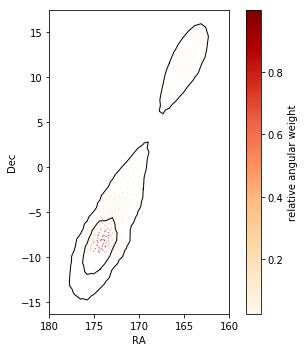

In [11]:
# Plot merged targets color-coded by relative angular probability from GW event.
fig, ax = plt.subplots(1,1, figsize=(5,5), tight_layout=True)
sc = ax.scatter(bmerg90['RA'][::100], bmerg90['DEC'][::100], s=0.1, c=bmerg90['Pr_radec'][::100], cmap='OrRd')
cb = fig.colorbar(sc, ax=ax)
cb.set_label('relative angular weight')

# Compute GW contours for degraded map.
for i, (rc, dc) in enumerate(zip(ra_contour, dec_contour)):
    ax.plot(rc, dc, linewidth=1, color='k')

ax.set(xlim=(180,160), xlabel='RA', ylabel='Dec', aspect='equal');

#### Plot Luminosity Distances

For the BGS bright targets, plot the distribution of luminosity distances calculated using the DR8 photo-z catalog.

27817 / 60430 = 46.0% in D_L 90% region


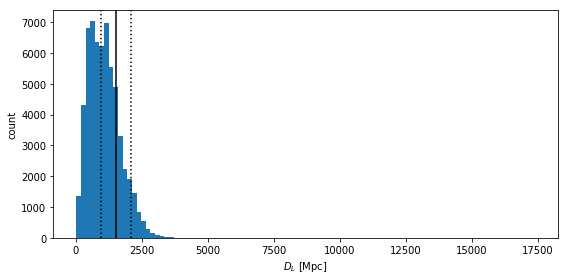

In [12]:
dL_min = np.min(bmerg90['D_L'])
dL_max = np.max(bmerg90['D_L'])

select = np.logical_and(bmerg90['D_L'] > dl90_lo, bmerg90['D_L'] < dl90_hi)
print('{:d} / {:d} = {:.1f}% in D_L 90% region'.format(np.sum(select), len(bmerg90), 1e2*np.sum(select)/len(bmerg90)))

fig, ax = plt.subplots(1,1, figsize=(8,4), tight_layout=True)
ax.hist(bmerg90['D_L'], bins=np.linspace(dL_min, dL_max, 100))
ax.axvline(distmean, color='k', ls='-')
ax.axvline(dl90_lo, color='k', ls=':')
ax.axvline(dl90_hi, color='k', ls=':')
ax.set(xlabel='$D_L$ [Mpc]',
       ylabel='count');